<a href="https://colab.research.google.com/github/MaxDixx/AutoEncoder/blob/main/autoencoder_AndhikaRachmatFauzi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 249M/249M [00:01<00:00, 169MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ckay16/accident-detection-from-cctv-footage/versions/1
Copied 989 images to 'frames'
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 182MB/s]


989 images found in 'frames'
Epoch 1 | Loss: 0.0168 | PSNR: 18.34dB
Epoch 2 | Loss: 0.0069 | PSNR: 21.67dB
Epoch 3 | Loss: 0.0054 | PSNR: 22.68dB
Epoch 4 | Loss: 0.0045 | PSNR: 23.50dB
Epoch 5 | Loss: 0.0038 | PSNR: 24.22dB


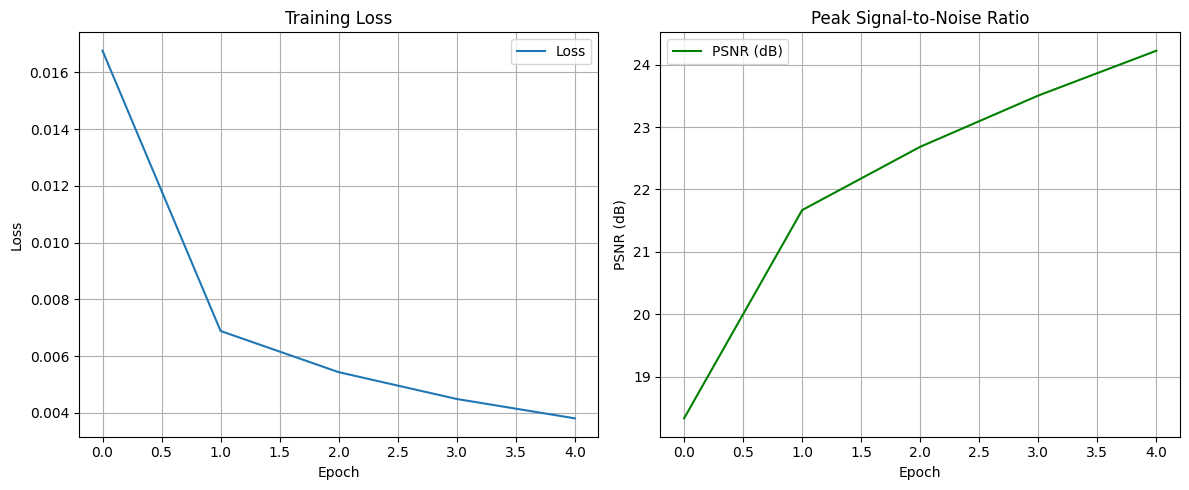

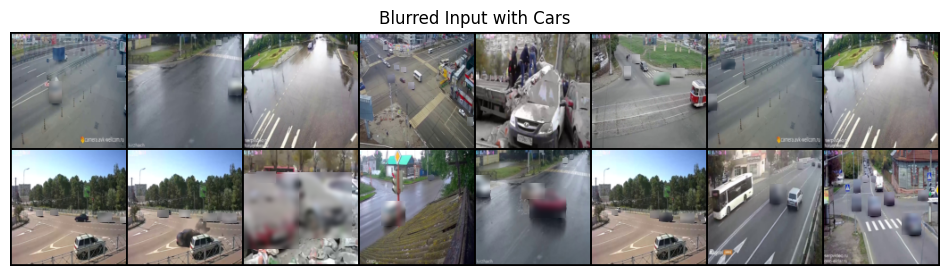

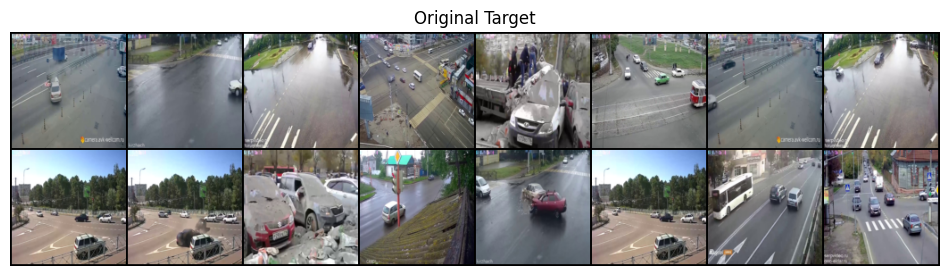

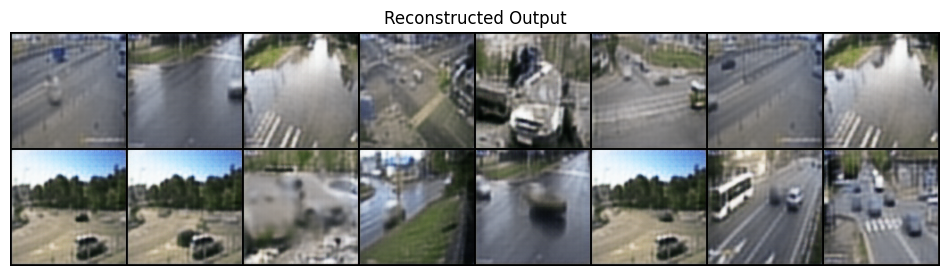

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import save_image, make_grid
from torchvision.transforms import functional as TF
from PIL import Image
import os
import kagglehub
import shutil
from math import log10
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. Download dataset dari KaggleHub
path = kagglehub.dataset_download("ckay16/accident-detection-from-cctv-footage")
print("Path to dataset files:", path)

# 2. Pindahkan semua gambar ke folder 'frames'
frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)

image_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith((".jpg", ".png")):
            src_path = os.path.join(root, file)
            dst_path = os.path.join(frames_dir, file)
            shutil.copy(src_path, dst_path)
            image_paths.append(dst_path)

print(f"Copied {len(image_paths)} images to '{frames_dir}'")

# 3. Cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 4. Transformasi gambar
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 5. Load pretrained object detector (Faster R-CNN)
detection_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
detection_model.eval().to(device)

# 6. Blur mobil secara otomatis

def blur_cars(image_tensor):
    image_pil = TF.to_pil_image(image_tensor)
    image_cv = np.array(image_pil)
    image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

    with torch.no_grad():
        input_tensor = image_tensor.unsqueeze(0).to(device)
        pred = detection_model(input_tensor)[0]

    for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
        if label == 3 and score > 0.7:  # Label 3 adalah 'car'
            x1, y1, x2, y2 = map(int, box.cpu())
            roi = image_cv[y1:y2, x1:x2]
            blurred = cv2.GaussianBlur(roi, (15, 15), 0)
            image_cv[y1:y2, x1:x2] = blurred

    image_blurred = Image.fromarray(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    return transform(image_blurred)

# 7. Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        print(f"{len(self.image_files)} images found in '{image_dir}'")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        image = transform(image)
        blurred = blur_cars(image)
        return blurred, image

# 8. Load dataset
dataset = CustomImageDataset(frames_dir, transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 9. Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 10. Inisialisasi model
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 11. Training
os.makedirs("results", exist_ok=True)
losses = []
psnr_scores = []

def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 10 * log10(1 / mse.item())

for epoch in range(5):
    model.train()
    total_loss = 0
    total_psnr = 0
    count = 0

    for blurred, original in loader:
        blurred = blurred.to(device)
        original = original.to(device)
        output = model(blurred)
        loss = criterion(output, original)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_psnr += calculate_psnr(original, output)
        count += 1

    avg_loss = total_loss / count
    avg_psnr = total_psnr / count
    losses.append(avg_loss)
    psnr_scores.append(avg_psnr)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | PSNR: {avg_psnr:.2f}dB")

# 12. Plot grafik Loss & PSNR
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(psnr_scores, label="PSNR (dB)", color="green")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.title("Peak Signal-to-Noise Ratio")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 13. Visualisasi hasil
model.eval()
with torch.no_grad():
    for blurred, original in loader:
        blurred = blurred.to(device)
        original = original.to(device)
        output = model(blurred)
        break

def show_tensor_images(tensor, nrow=8, title=""):
    grid = make_grid(tensor.cpu(), nrow=nrow, normalize=True)
    npimg = grid.permute(1, 2, 0).numpy()
    plt.figure(figsize=(12, 6))
    plt.imshow(npimg)
    plt.axis('off')
    plt.title(title)
    plt.show()

show_tensor_images(blurred, title="Blurred Input with Cars")
show_tensor_images(original, title="Original Target")
show_tensor_images(output, title="Reconstructed Output")
